## Введение

Работа по освоению линейной регрессии, используя библиотеку pytorch. Для этого считаю необходимым написать базовый алгоритм самостоятельно, а потом сравнить его с готовым из пакета sklearn. Для работы буду использовать модель линейной регрессии с L2 регуляризацией и стохастическим градиентным спуском в виде оптимизатора. 

## Импортируем все необходимое

In [1]:
import torch
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Подготовка



Создадим класс, отвечающий за стандартизацию, который может быть интегрирован в nn.Sequential

In [2]:
class Standardscaler(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_batch):
        std, mean = torch.std_mean(input_batch.type(torch.float32), unbiased=False)
        total = (input_batch - mean) / std
        return total

## Инициализация 

In [3]:
boston = load_boston()

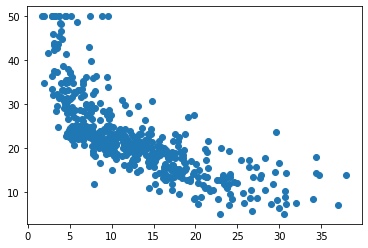

In [4]:
plt.scatter(boston.data[:,-1],boston.target)

Займемся предобработкой данных:
1. Разделим данные на тестовую выборку и тренировочную 
1. Преобразуем данные в формат подходящий для обработки pytorch

In [5]:
train_X,test_X,train_Y,test_Y = train_test_split(boston.data,
                                                 boston.target,
                                                 test_size = 0.33,
                                                 random_state = 42)

train_X_torch = torch.tensor(train_X, dtype = torch.float32)
train_Y_torch = torch.tensor(train_Y, dtype = torch.float32)
test_X_torch = torch.tensor(test_X, dtype = torch.float32)
test_Y_torch = torch.tensor(test_Y, dtype = torch.float32)



Создаем модель линйной регрессии реализованной при помощи pytorch

In [6]:
class LinearRegressionSGD_torch():
    def __init__(self,n_features, lr = 0.001, l2 = 1,max_iter = 1000):
        self.n_features = n_features
        self.model = torch.nn.Sequential()
        self.model.add_module('first',Standardscaler())
        self.model.add_module('second',torch.nn.Linear(n_features,1))
        self.lr = lr
        self.l2 = l2
        self.max_iter = max_iter
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         lr = self.lr,
                                         weight_decay = self.l2)
        
        
    def fit(self,design_matrix, target):
        for i in range(self.max_iter):
            sampling  = np.random.randint(0,design_matrix.shape[1],10)

            part_design_matrix = design_matrix[sampling]
            part_target_vector = target[sampling]

            pred = self.model(part_design_matrix) 
            loss = torch.mean((part_target_vector - pred)**2)
            loss.backward()  
            self.optimizer.step()
            self.optimizer.zero_grad()

        return self.model
    
    def predict(self, design_matrix):
        return self.model(design_matrix)


    


## Создаем объекты моделей, обединяем их в pipeline и тренеруем


In [7]:
torch_LinearRegression = LinearRegressionSGD_torch(train_X_torch.shape[1])
torch_LinearRegression.fit(train_X_torch,train_Y_torch)

Sequential(
  (first): Standardscaler()
  (second): Linear(in_features=13, out_features=1, bias=True)
)

In [8]:
package_pipe = make_pipeline(StandardScaler(),SGDRegressor(max_iter = 1000))
package_pipe.fit(train_X,train_Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
                              epsilon=0.1, eta0=0.01, fit_intercept=True,
                              l1_ratio=0.15, learning_rate='invscaling',
                              loss='squared_loss', max_iter=1000,
                              n_iter_no_change=5, penalty='l2', power_t=0.25,
                              random_state=None, shuffle=True, tol=0.001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
         verbose=False)

## Предсказываем метки

In [9]:
sklearn_pred  = package_pipe.predict(test_X)
self_torch_pred = torch_LinearRegression.predict(test_X_torch)

 ## Высчитываем ошибку каждой модели

In [10]:
torch_loss = torch.mean((test_Y_torch - self_torch_pred)**2)
sklearn_loss = np.mean((test_Y - sklearn_pred)**2)

## Итоги

In [11]:
print('Ошибка полученная на предсказаниях проведенныйх ручным алгоритмом {:.3f} и алгоритмом sklearn {:.3f}'.format(torch_loss, sklearn_loss))
print("Разница между результатами составила: {:.3}".format(abs(torch_loss - sklearn_loss)))

Ошибка полученная на предсказаниях проведенныйх ручным алгоритмом 85.064 и алгоритмом sklearn 21.223
Разница между результатами составила: 63.8
